<a href="https://colab.research.google.com/github/MSIMulti/AIFFEL_quest_cr/blob/master/test_src/pybullet_colab_test_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics opencv-python pybullet matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 7.2 MB/s eta 0:00:00


프레임 처리 중...

0: 640x384 1 tv, 179.2ms
Speed: 6.5ms preprocess, 179.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)
탐지된 공 좌표: [(tensor(180.1725), tensor(308.8757))]
PyBullet 좌표: [tensor(0.0014), tensor(-0.0247), 0.028]


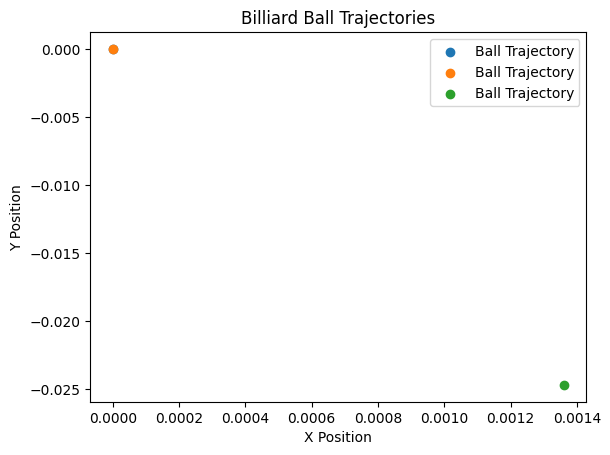

In [ ]:
import cv2
import numpy as np
import pybullet as p
import pybullet_data
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os

# YOLO 모델 로드
model = YOLO("yolov8n.pt")  # YOLO 모델 파일

# 비디오 파일 경로
video_path = "/content/drive/MyDrive/billiard_game.mp4"
if not os.path.exists(video_path):
    print("비디오 파일이 존재하지 않습니다. 경로를 확인하세요.")
    exit()

# 비디오 캡처 객체 생성
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("비디오 파일을 열 수 없습니다.")
    exit()

# PyBullet 초기화
p.connect(p.DIRECT)  # 헤드리스 모드로 실행
p.setAdditionalSearchPath(pybullet_data.getDataPath())
plane_id = p.loadURDF("plane.urdf")
table_id = p.createCollisionShape(p.GEOM_BOX, halfExtents=[1.5, 0.75, 0.01])  # 당구대 크기
p.createMultiBody(baseCollisionShapeIndex=table_id, basePosition=[0, 0, -0.01])

# 공의 속성
BALL_RADIUS = 0.028
BALL_MASS = 0.17

# 공을 PyBullet 시뮬레이션에 추가
def add_ball(position, velocity):
    ball_id = p.createCollisionShape(p.GEOM_SPHERE, radius=BALL_RADIUS)
    body_id = p.createMultiBody(
        baseMass=BALL_MASS,
        baseCollisionShapeIndex=ball_id,
        basePosition=position,
    )
    p.resetBaseVelocity(body_id, linearVelocity=velocity)
    return body_id

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("비디오를 더 이상 읽을 수 없습니다.")
        break

    print("프레임 처리 중...")

    # 프레임을 RGB로 변환 (YOLO 요구 사항)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # YOLO 객체 감지
    results = model(frame_rgb, conf=0.5)  # YOLO 모델 사용
    balls = []
    for result in results[0].boxes:  # 각 탐지된 객체에 접근
        x1, y1, x2, y2 = result.xyxy[0]  # 경계 상자 좌표
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2  # 중심 좌표 계산
        balls.append((cx, cy))

    print(f"탐지된 공 좌표: {balls}")

    # PyBullet 좌표로 변환 및 공 추가
    p.resetSimulation()
    p.loadURDF("plane.urdf")
    p.createMultiBody(baseCollisionShapeIndex=table_id, basePosition=[0, 0, -0.01])

    for ball in balls:
        px, py = ball
        position = [(px / frame_width) * 2.84 - 1.42, (py / frame_height) * 1.42 - 0.71, BALL_RADIUS]
        print(f"PyBullet 좌표: {position}")
        add_ball(position, [0, 0, 0])

    # 궤적 시뮬레이션
    for _ in range(120):  # 120 스텝 시뮬레이션
        p.stepSimulation()

    # 궤적 시각화
    ball_positions = [
        p.getBasePositionAndOrientation(body_id)[0][:2]
        for body_id in range(p.getNumBodies())
    ]
    if ball_positions:
        for path in ball_positions:
            plt.scatter(*path, label="Ball Trajectory")
        plt.legend()
        plt.title("Billiard Ball Trajectories")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.show()

    break  # 첫 번째 프레임만 처리

cap.release()
cv2.destroyAllWindows()
p.disconnect()